# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import time
import pickle
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, recall_score, roc_curve, precision_score
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import re
from androguard.core.bytecodes.apk import APK
from androguard.core.bytecodes.dvm import DalvikVMFormat
from androguard.misc import AnalyzeAPK

from mlxtend.plotting import plot_confusion_matrix
from scikitplot.metrics import plot_cumulative_gain, plot_precision_recall, plot_roc_curve
PROJECT_ROOT_DIR = ".."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
np.random.seed(42)

def save_fig(title):
    path = os.path.join(IMAGES_PATH, title + ".png")
    plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

# Load Data

In [2]:
data = pd.read_csv("../dataset/drebin-215-dataset-5560malware-9476-benign.csv", encoding="utf-8", low_memory=False, na_values="?")

In [3]:
data.head()

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S


In [4]:
data.shape

(15036, 216)

In [5]:
data.isnull().sum().sum()

5

In [6]:
feature_df = pd.read_csv("../dataset/dataset-features-categories.csv", header=None, names=["X", "Category"])

In [7]:
feature_df.tail()

,X,Category
211,ACCESS_FINE_LOCATION,Manifest Permission
212,SET_WALLPAPER_HINTS,Manifest Permission
213,SET_PREFERRED_APPLICATIONS,Manifest Permission
214,WRITE_SECURE_SETTINGS,Manifest Permission
215,class,B=Benign; S=Malware


In [8]:
feature_df["Category"].value_counts()

Manifest Permission    113
API call signature      73
Intent                  23
Commands signature       6
B=Benign; S=Malware      1
Name: Category, dtype: int64

In [9]:
feature_df.shape

(216, 2)

In [10]:
feature_df.isnull().sum().sum()

0

In [11]:
feature_df[feature_df["Category"] == "Manifest Permission"]

,X,Category
6,SEND_SMS,Manifest Permission
13,READ_PHONE_STATE,Manifest Permission
19,GET_ACCOUNTS,Manifest Permission
20,RECEIVE_SMS,Manifest Permission
22,READ_SMS,Manifest Permission
...,...,...
210,WRITE_EXTERNAL_STORAGE,Manifest Permission
211,ACCESS_FINE_LOCATION,Manifest Permission
212,SET_WALLPAPER_HINTS,Manifest Permission
213,SET_PREFERRED_APPLICATIONS,Manifest Permission


In [181]:
feature_df[feature_df["Category"] == "API call signature"]

,X,Category
0,transact,API call signature
1,onServiceConnected,API call signature
2,bindService,API call signature
3,attachInterface,API call signature
4,ServiceConnection,API call signature
...,...,...
167,ProcessBuilder,API call signature
171,Ljava.lang.Class.getResource,API call signature
172,defineClass,API call signature
180,findClass,API call signature


In [182]:
feature_df[feature_df["Category"] == "Intent"]

,X,Category
25,android.intent.action.BOOT_COMPLETED,Intent
53,android.intent.action.PACKAGE_REPLACED,Intent
55,android.intent.action.SEND_MULTIPLE,Intent
66,android.intent.action.TIME_SET,Intent
73,android.intent.action.PACKAGE_REMOVED,Intent
74,android.intent.action.TIMEZONE_CHANGED,Intent
81,android.intent.action.ACTION_POWER_DISCONNECTED,Intent
82,android.intent.action.PACKAGE_ADDED,Intent
97,android.intent.action.ACTION_SHUTDOWN,Intent
107,android.intent.action.PACKAGE_DATA_CLEARED,Intent


In [183]:
feature_df[feature_df["Category"] == "Commands signature"]

,X,Category
44,mount,Commands signature
79,chmod,Commands signature
96,remount,Commands signature
100,chown,Commands signature
141,/system/bin,Commands signature
149,/system/app,Commands signature


# Preprocess

In [65]:
data["class"] = data["class"].map({"B": 0, "S": 1})

In [66]:
data.head()

,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1


In [67]:
data = data.dropna()

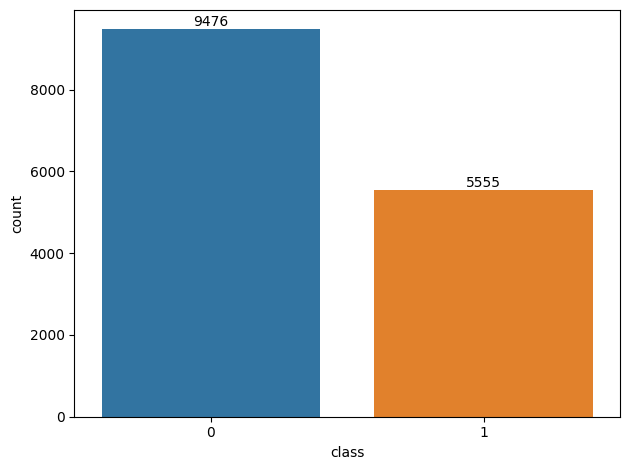

In [68]:
plt.figure()
ax = sns.countplot(data=data, x="class")
for container in ax.containers:
    ax.bar_label(container)
save_fig("before_random_over_sampler")
plt.show()

In [69]:
X = data.drop("class", axis=1)
y = data["class"]

In [70]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

In [71]:
print(Counter(y))
print(Counter(y_ros))

Counter({0: 9476, 1: 5555})
Counter({1: 9476, 0: 9476})


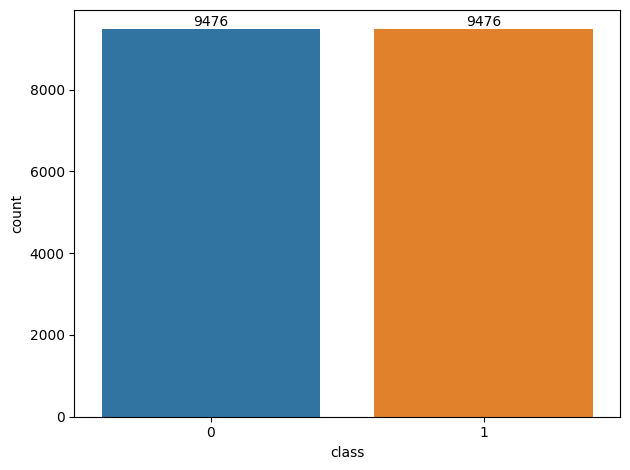

In [72]:
plt.figure()
ax = sns.countplot(x=y_ros)
for container in ax.containers:
    ax.bar_label(container)
save_fig("after_random_over_sampler")
plt.show()

# Model

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42)

### Logistic Regression

In [75]:
logreg = LogisticRegression()
start = time.time()
logreg.fit(X_train, y_train)
end = time.time()
logreg_time = end - start
print("Logistic Regression Train Time:", logreg_time)

Logistic Regression Train Time: 0.3322608470916748


In [78]:
pickle.dump(logreg, open("../models/logreg.pkl", "wb"))

In [82]:
logreg_scores = cross_val_score(logreg, X_train, y_train, cv=3)
print("Logistic Regression Cross-Validation Accuracy Scores:\n", logreg_scores)

Logistic Regression Cross-Validation Accuracy Scores:
 [0.97625643 0.9758607  0.97407481]


In [83]:
logreg_pred_train = logreg.predict(X_train)
logreg_pred_test = logreg.predict(X_test)

logreg_train_score = accuracy_score(logreg_pred_train, y_train)
logreg_test_score = accuracy_score(logreg_pred_test, y_test)
print("Logistic Regression Train Score:", logreg_train_score)
print("Logistic Regression Test Score:", logreg_test_score)

Logistic Regression Train Score: 0.9807400567244905
Logistic Regression Test Score: 0.9754682141915062


In [84]:
logreg_precision_score = precision_score(y_test, logreg_pred_test)
logreg_f1_score = f1_score(y_test, logreg_pred_test)
logreg_recall_score = recall_score(y_test, logreg_pred_test)
logreg_accuracy_score = accuracy_score(y_test, logreg_pred_test)

print("Logistic Regression Precision Score:", logreg_precision_score)
print("Logistic Regression F1 Score:", logreg_f1_score)
print("Logistic Regression Recall Score:", logreg_recall_score)
print("Logistic Regression Accuracy Score:", logreg_accuracy_score)

Logistic Regression Precision Score: 0.9771366358192706
Logistic Regression F1 Score: 0.9747488460494163
Logistic Regression Recall Score: 0.9723726977248104
Logistic Regression Accuracy Score: 0.9754682141915062


In [85]:
print(classification_report(y_test, logreg_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1945
           1       0.98      0.97      0.97      1846

    accuracy                           0.98      3791
   macro avg       0.98      0.98      0.98      3791
weighted avg       0.98      0.98      0.98      3791



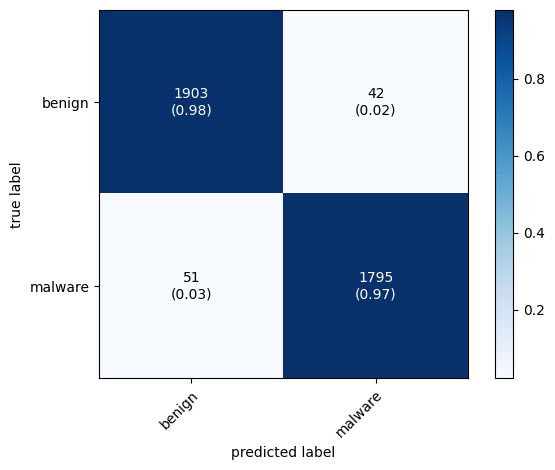

In [86]:
logreg_cm = confusion_matrix(y_test, logreg_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=logreg_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("logistic_regression_pred_test_confusion_matrix")
plt.show()

In [87]:
logreg_test_proba = logreg.predict_proba(X_test)

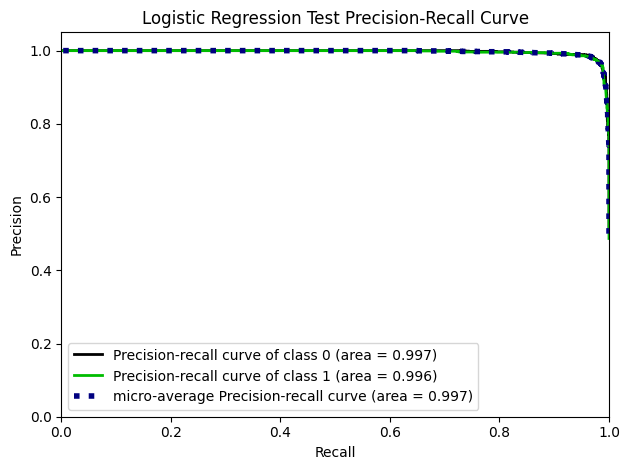

In [88]:
plot_precision_recall(y_test, logreg_test_proba, title="Logistic Regression Test Precision-Recall Curve")
save_fig("logistic_regression_test_precision_recall_curve")
plt.show()

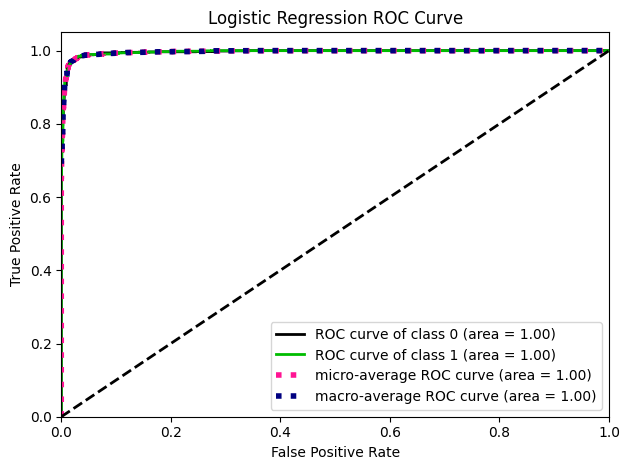

In [90]:
plot_roc_curve(y_test, logreg_test_proba, title="Logistic Regression ROC Curve")
save_fig("logistic_regression_roc_curve")
plt.show()

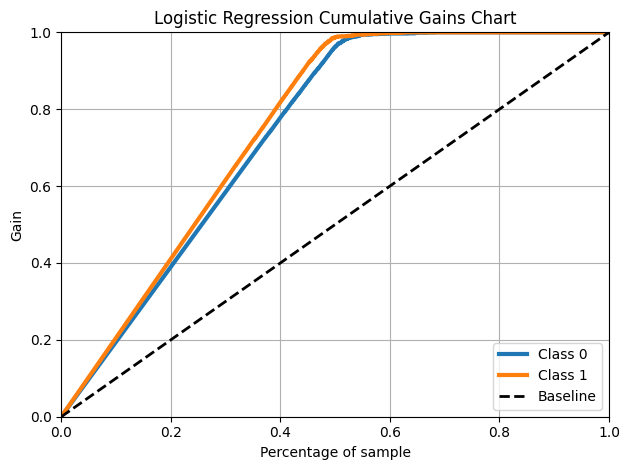

In [91]:
plot_cumulative_gain(y_test, logreg_test_proba, title="Logistic Regression Cumulative Gains Chart")
save_fig("logistic_regression_cumulative_gains")
plt.show()

# Random Forest

In [92]:
rf = RandomForestClassifier()
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
rf_time = end - start
print("Random Forest Train Time:", rf_time)

Random Forest Train Time: 1.2069625854492188


In [93]:
pickle.dump(rf, open("../models/rf.pkl", "wb"))

In [94]:
rf_scores = cross_val_score(rf, X_train, y_train, cv=3)
print("Random Forest Cross-Validation Accuracy Scores:\n", rf_scores)

Random Forest Cross-Validation Accuracy Scores:
 [0.99149189 0.9908983  0.98713635]


In [95]:
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

rf_train_score = accuracy_score(rf_pred_train, y_train)
rf_test_score = accuracy_score(rf_pred_test, y_test)
print("Random Forest Train Score:", rf_train_score)
print("Random Forest Test Score:", rf_test_score)

Random Forest Train Score: 0.9987467845128949
Random Forest Test Score: 0.9928778686362437


In [96]:
rf_precision_score = precision_score(y_test, rf_pred_test)
rf_f1_score = f1_score(y_test, rf_pred_test)
rf_recall_score = recall_score(y_test, rf_pred_test)
rf_accuracy_score = accuracy_score(y_test, rf_pred_test)

print("Random Forest Precision Score:", rf_precision_score)
print("Random Forest F1 Score:", rf_f1_score)
print("Random Forest Recall Score:", rf_recall_score)
print("Random Forest Accuracy Score:", rf_accuracy_score)

Random Forest Precision Score: 0.9961811238406983
Random Forest F1 Score: 0.9926610491981518
Random Forest Recall Score: 0.9891657638136512
Random Forest Accuracy Score: 0.9928778686362437


In [97]:
print(classification_report(y_test, rf_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1945
           1       1.00      0.99      0.99      1846

    accuracy                           0.99      3791
   macro avg       0.99      0.99      0.99      3791
weighted avg       0.99      0.99      0.99      3791



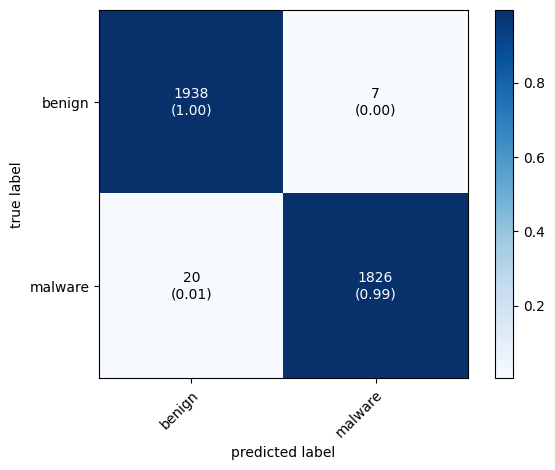

In [98]:
rf_cm = confusion_matrix(y_test, rf_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=rf_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("random_forest_pred_test_confusion_matrix")
plt.show()

In [99]:
rf_test_proba = rf.predict_proba(X_test)

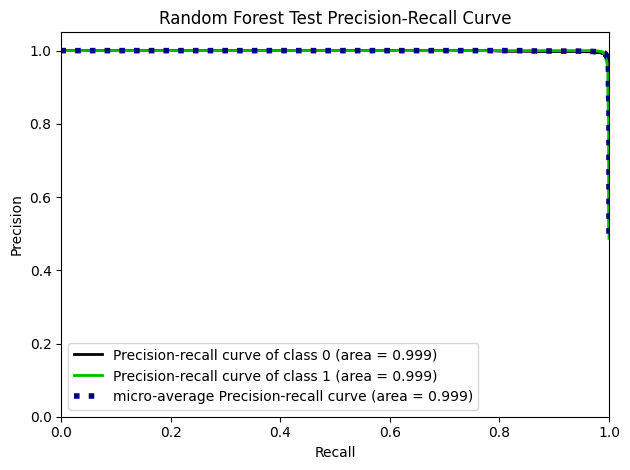

In [100]:
plot_precision_recall(y_test, rf_test_proba, title="Random Forest Test Precision-Recall Curve")
save_fig("random_forest_test_precision_recall_curve")
plt.show()

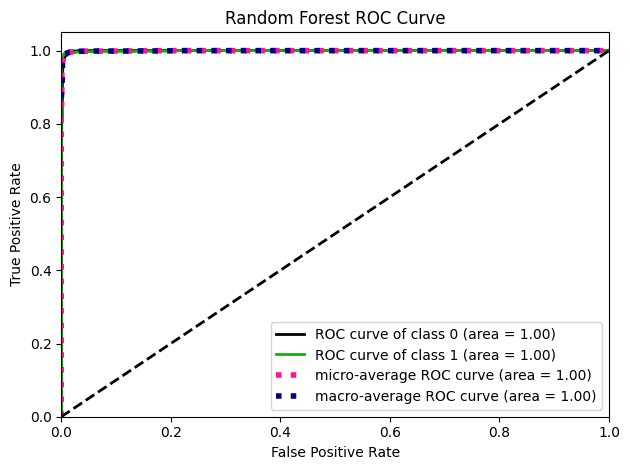

In [101]:
plot_roc_curve(y_test, rf_test_proba, title="Random Forest ROC Curve")
save_fig("random_forest_roc_curve")
plt.show()

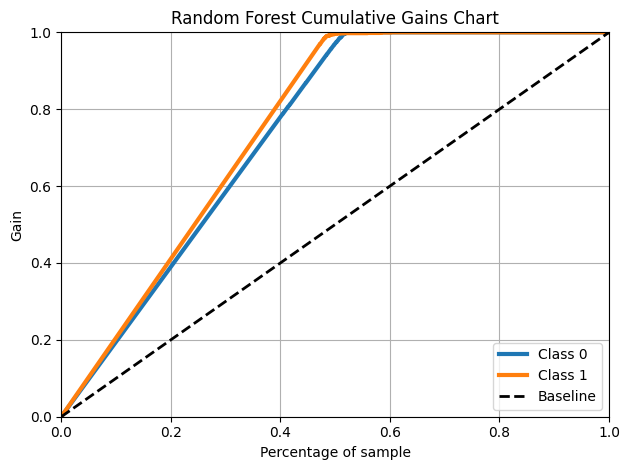

In [102]:
plot_cumulative_gain(y_test, rf_test_proba, title="Random Forest Cumulative Gains Chart")
save_fig("random_forest_cumulative_gains")
plt.show()

In [103]:
for name, score in zip(X.columns, rf.feature_importances_):
    print(name, score)

transact 0.03223852359667139
onServiceConnected 0.03895795217162492
bindService 0.03520282277871129
attachInterface 0.05358027994155856
ServiceConnection 0.025358501435129754
android.os.Binder 0.04062751982195214
SEND_SMS 0.06127075865625191
Ljava.lang.Class.getCanonicalName 0.03214621038279547
Ljava.lang.Class.getMethods 0.021726986443657784
Ljava.lang.Class.cast 0.02122302766155412
Ljava.net.URLDecoder 0.012370342823808224
android.content.pm.Signature 0.013519073135107558
android.telephony.SmsManager 0.028383685810399115
READ_PHONE_STATE 0.04919987323749501
getBinder 0.011083182560075231
ClassLoader 0.009121958627088018
Landroid.content.Context.registerReceiver 0.00859054075352062
Ljava.lang.Class.getField 0.010667414981616073
Landroid.content.Context.unregisterReceiver 0.014294852928289166
GET_ACCOUNTS 0.006815575293578021
RECEIVE_SMS 0.017561501104322585
Ljava.lang.Class.getDeclaredField 0.006566266091973401
READ_SMS 0.012778913536092694
getCallingUid 0.0021208478546084534
Ljavax.c

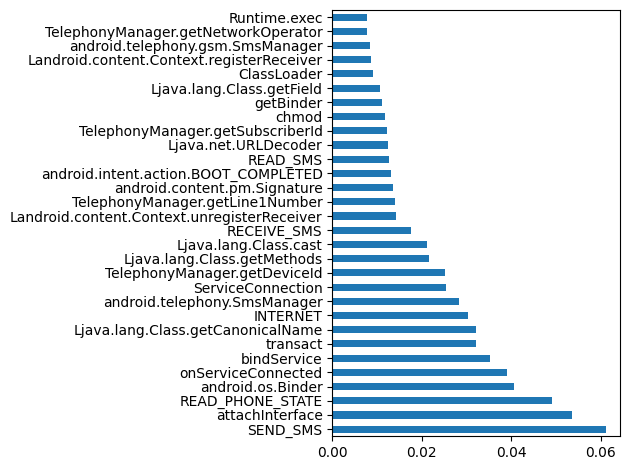

In [106]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')
save_fig("rf_feature_importances")
plt.show()

# Decision Tree

In [107]:
dt = DecisionTreeClassifier()
start = time.time()
dt.fit(X_train, y_train)
end = time.time()
dt_time = end - start
print("Decision Tree Train Time:", dt_time)

Decision Tree Train Time: 0.1999664306640625


In [108]:
pickle.dump(dt, open("../models/dt.pkl", "wb"))

In [109]:
dt_scores = cross_val_score(dt, X_train, y_train, cv=3)
print("Decision Tree Cross-Validation Accuracy Scores:\n", dt_scores)

Decision Tree Cross-Validation Accuracy Scores:
 [0.97783934 0.97546498 0.97684544]


In [110]:
dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)

dt_train_score = accuracy_score(dt_pred_train, y_train)
dt_test_score = accuracy_score(dt_pred_test, y_test)
print("Decision Tree Train Score:", dt_train_score)
print("Decision Tree Test Score:", dt_test_score)

Decision Tree Train Score: 0.9987467845128949
Decision Tree Test Score: 0.978106040622527


In [111]:
dt_precision_score = precision_score(y_test, dt_pred_test)
dt_f1_score = f1_score(y_test, dt_pred_test)
dt_recall_score = recall_score(y_test, dt_pred_test)
dt_accuracy_score = accuracy_score(y_test, dt_pred_test)

print("Decision Tree Precision Score:", dt_precision_score)
print("Decision Tree F1 Score:", dt_f1_score)
print("Decision Tree Recall Score:", dt_recall_score)
print("Decision Tree Accuracy Score:", dt_accuracy_score)

Decision Tree Precision Score: 0.9686337054758107
Decision Tree F1 Score: 0.9777300778105715
Decision Tree Recall Score: 0.9869989165763814
Decision Tree Accuracy Score: 0.978106040622527


In [112]:
print(classification_report(y_test, dt_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1945
           1       0.97      0.99      0.98      1846

    accuracy                           0.98      3791
   macro avg       0.98      0.98      0.98      3791
weighted avg       0.98      0.98      0.98      3791



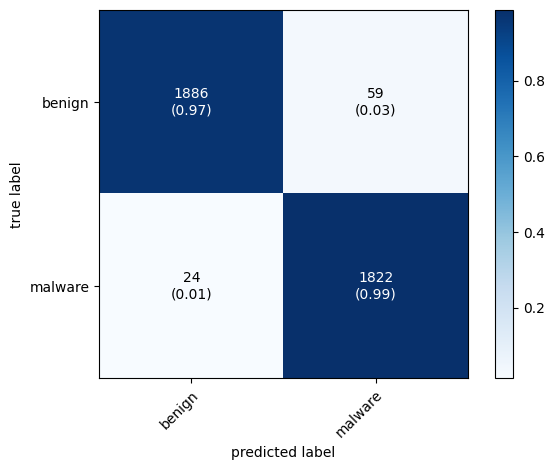

In [114]:
dt_cm = confusion_matrix(y_test, dt_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=dt_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("decision_tree_pred_test_confusion_matrix")
plt.show()

In [116]:
dt_test_proba = dt.predict_proba(X_test)

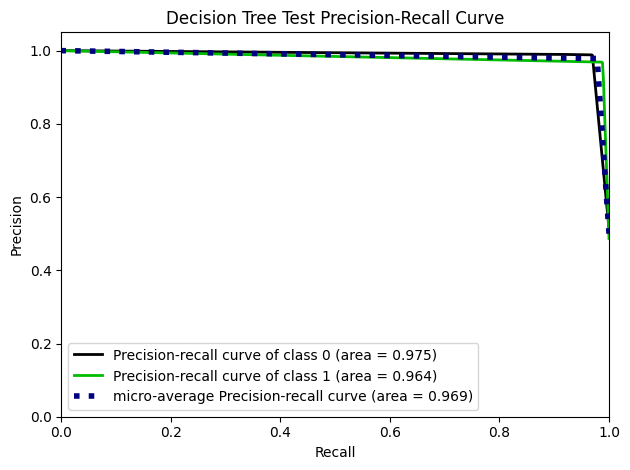

In [118]:
plot_precision_recall(y_test, dt_test_proba, title="Decision Tree Test Precision-Recall Curve")
save_fig("decision_tree_test_precision_recall_curve")
plt.show()

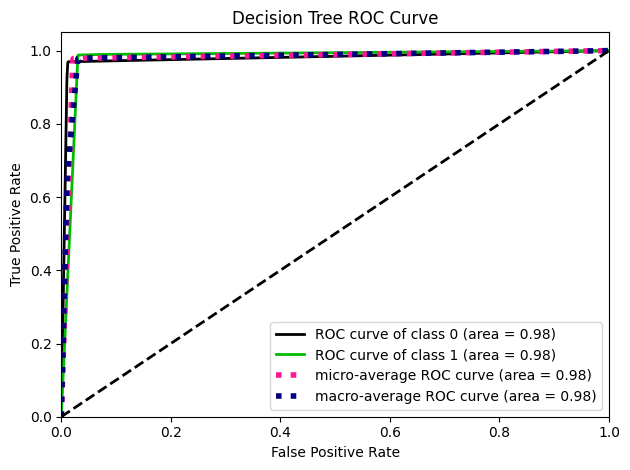

In [119]:
plot_roc_curve(y_test, dt_test_proba, title="Decision Tree ROC Curve")
save_fig("decision_tree_roc_curve")
plt.show()

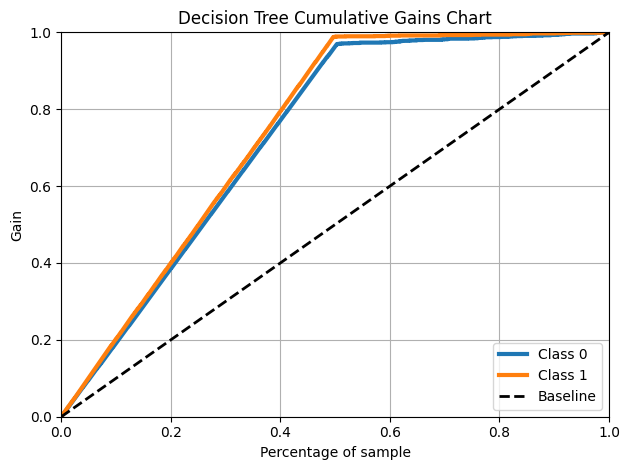

In [120]:
plot_cumulative_gain(y_test, dt_test_proba, title="Decision Tree Cumulative Gains Chart")
save_fig("decision_tree_cumulative_gains")
plt.show()

# XGB

In [121]:
xgb = XGBClassifier()
start = time.time()
xgb.fit(X_train, y_train)
end = time.time()
xgb_time = end - start
print("XGBClassifier Train Time:", xgb_time)

XGBClassifier Train Time: 0.44280195236206055


In [122]:
pickle.dump(xgb, open("../models/xgb.pkl", "wb"))

In [123]:
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=3)
print("XGBClassifier Cross-Validation Accuracy Scores:\n", xgb_scores)

XGBClassifier Cross-Validation Accuracy Scores:
 [0.99149189 0.98971112 0.98852167]


In [124]:
xgb_pred_train = xgb.predict(X_train)
xgb_pred_test = xgb.predict(X_test)

xgb_train_score = accuracy_score(xgb_pred_train, y_train)
xgb_test_score = accuracy_score(xgb_pred_test, y_test)
print("XGBClassifier Train Score:", xgb_train_score)
print("XGBClassifier Test Score:", xgb_test_score)

XGBClassifier Train Score: 0.9972297341863993
XGBClassifier Test Score: 0.9891849116328145


In [125]:
xgb_precision_score = precision_score(y_test, xgb_pred_test)
xgb_f1_score = f1_score(y_test, xgb_pred_test)
xgb_recall_score = recall_score(y_test, xgb_pred_test)
xgb_accuracy_score = accuracy_score(y_test, xgb_pred_test)

print("XGBClassifier Precision Score:", xgb_precision_score)
print("XGBClassifier F1 Score:", xgb_f1_score)
print("XGBClassifier Recall Score:", xgb_recall_score)
print("XGBClassifier Accuracy Score:", xgb_accuracy_score)

XGBClassifier Precision Score: 0.9912901469787697
XGBClassifier F1 Score: 0.9888677708389899
XGBClassifier Recall Score: 0.9864572047670639
XGBClassifier Accuracy Score: 0.9891849116328145


In [126]:
print(classification_report(y_test, xgb_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1945
           1       0.99      0.99      0.99      1846

    accuracy                           0.99      3791
   macro avg       0.99      0.99      0.99      3791
weighted avg       0.99      0.99      0.99      3791



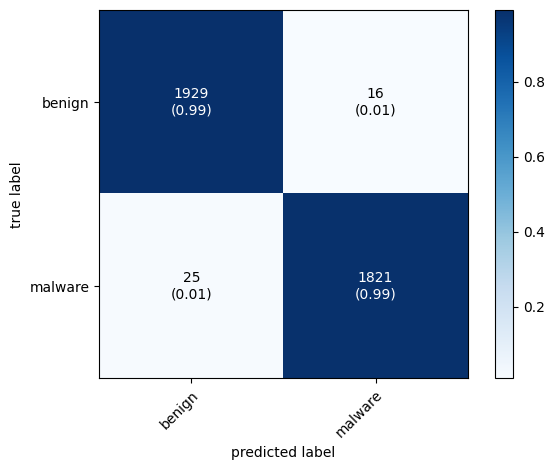

In [127]:
xgb_cm = confusion_matrix(y_test, xgb_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=xgb_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["benign", "malware"])
save_fig("xgb_pred_test_confusion_matrix")
plt.show()

In [130]:
xgb_test_proba = xgb.predict_proba(X_test)

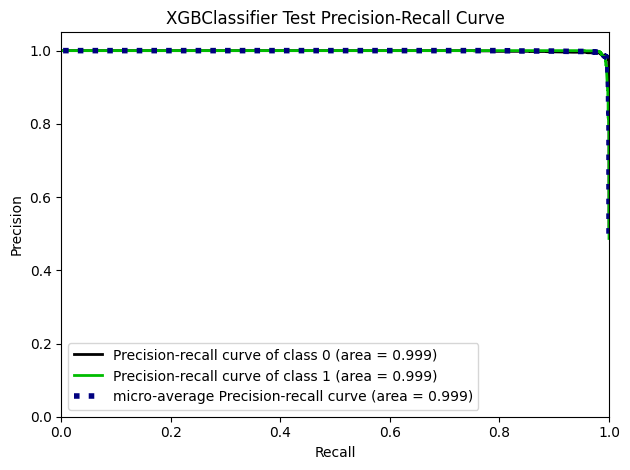

In [132]:
plot_precision_recall(y_test, xgb_test_proba, title="XGBClassifier Test Precision-Recall Curve")
save_fig("xgb_test_precision_recall_curve")
plt.show()

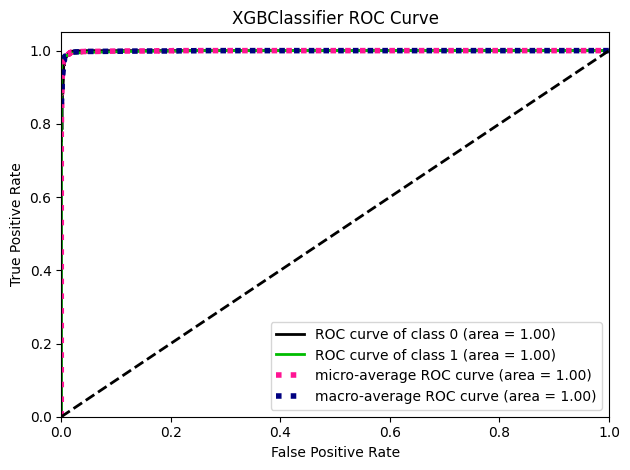

In [133]:
plot_roc_curve(y_test, xgb_test_proba, title="XGBClassifier ROC Curve")
save_fig("xgb_roc_curve")
plt.show()

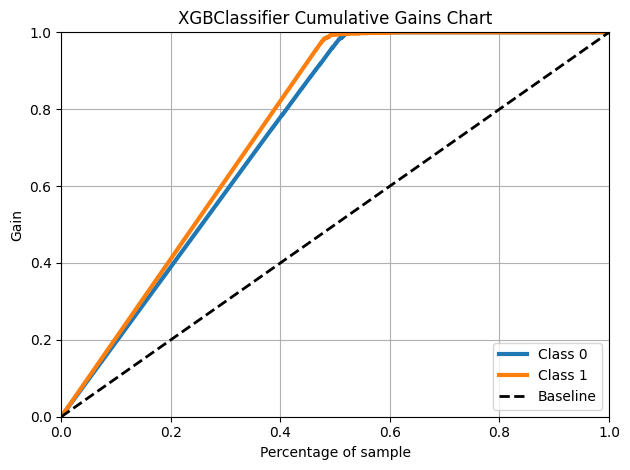

In [135]:
plot_cumulative_gain(y_test, xgb_test_proba, title="XGBClassifier Cumulative Gains Chart")
save_fig("xgb_cumulative_gains")
plt.show()

In [136]:
labels = ["LR", "DT", "RF", "XGB"]
scores = [logreg_test_score, dt_test_score, rf_test_score, xgb_test_score]

In [137]:
def plot_model_plot(labels, scores):
    plt.figure()
    ax = sns.barplot(x=labels, y=scores)
    ax.set_title("Trained Models Accuracy")
    for container in ax.containers:
        ax.bar_label(container)

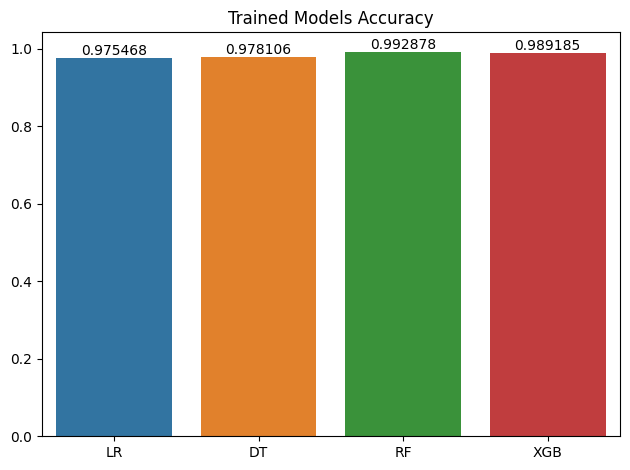

In [138]:
plot_model_plot(labels, scores)
save_fig("trained_models")
plt.show()

# Test

In [12]:
permissions_list = feature_df[feature_df["Category"] == "Manifest Permission"].X.unique()
api_call_signatures = feature_df[feature_df["Category"] == "API call signature"].X.unique()
intents = feature_df[feature_df["Category"] == "Intent"].X.unique()
keywords = feature_df[feature_df["Category"] == "Commands signature"].X.unique()

In [19]:
columns = ["filename"]
for col in data.columns:
    columns.append(col)

In [252]:
test_df = pd.DataFrame(columns=columns)

In [253]:
apk_file_path = "/home/alper/İndirilenler/app-debug.apk"

In [254]:
test_df.loc[0, "filename"] = apk_file_path

In [255]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
0,/home/alper/İndirilenler/app-debug.apk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [256]:
a = APK(apk_file_path)
d = DalvikVMFormat(a.get_dex())

Requested API level 33 is larger than maximum we have, returning API level 28 instead.


In [257]:
permissions = a.get_permissions()
manifest = a.get_android_manifest_xml()
intent_filters = manifest.findall(".//intent-filter")

In [258]:
found_permissions = []
found_api_signatures = []
found_intents = []
found_keywords = []

In [259]:
for permission in permissions:
    permission = permission.split(".")[-1]
    if permission in permissions_list:
        found_permissions.append(permission)

In [260]:
for permission in permissions_list:
    if permission in found_permissions:
        test_df[permission] = 1
    else:
        test_df[permission] = 0

In [261]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
0,/home/alper/İndirilenler/app-debug.apk,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [262]:
for method in d.get_methods():
    for api_call in api_call_signatures:
        if re.search(api_call, method.get_descriptor()):
            #print("[+]", perm, " found.")
            found_api_signatures.append(api_call)

In [263]:
for api_call in api_call_signatures:
    if api_call in found_api_signatures:
        test_df[api_call] = 1
    else:
        test_df[api_call] = 0

In [264]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
0,/home/alper/İndirilenler/app-debug.apk,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [265]:
for intent_filter in intent_filters:
    action_elements = intent_filter.findall(".//action")
    for action_element in action_elements:
        action_value = action_element.get("{http://schemas.android.com/apk/res/android}name")
        for intent in intents:
            if re.search(intent, action_value):
                found_intents.append(intent)

In [266]:
for intent in intents:
    if intent in found_intents:
        test_df[intent] = 1
    else:
        test_df[intent] = 0

In [267]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
0,/home/alper/İndirilenler/app-debug.apk,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
for method in d.get_methods():
    for keyword in keywords:
        try:
            if re.search(keyword, method.get_code().get_instruction()):
                found_keywords.append(keyword)
        except:
            pass

In [269]:
for keyword in keywords:
    if keyword in found_keywords:
        test_df[keyword] = 1
    else:
        test_df[keyword] = 0

In [270]:
test_df.head()

,filename,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,...,SET_ORIENTATION,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS
0,/home/alper/İndirilenler/app-debug.apk,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [271]:
test_df.isnull().sum().sum()

0

In [272]:
dropped = test_df.drop("filename", axis=1)

In [273]:
rf.predict(dropped)

array([0])